### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 4
### Due: Friday, Feb 21st at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [1]:
#import things
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
from scipy.stats import laplace
import corner
import numdifftools as nd
from scipy.stats import uniform

### Part 1

In [20]:
#1 same as HW3
#read in the data
data=np.load('../../../homeworks/hw_data/hw4_data_1.npy')
#slice array
voltage=data[:,0]
verror=data[:,1]
print(data)

#mean and se from formula in lecture 5
wm = np.sum((1 / (verror** 2)) * voltage) / np.sum((1 / (verror** 2))) #mean
wse= (np.sum((1 / (verror** 2)))) ** (-1/2) #standard error
print("mean",wm,"and standard error",wse)

[[4.36 2.24]
 [4.   1.94]
 [4.87 1.39]
 [5.64 2.55]
 [6.14 1.69]
 [5.92 1.38]
 [3.93 1.  ]
 [6.58 1.6 ]
 [3.78 1.  ]
 [5.84 1.  ]]
mean 4.942118214425304 and standard error 0.43024334605205083


### Part 2

In [165]:
#if this is gaussian data then we can use
#likelyhood from lecture 6
#creating a log likelyhood funciton from hw3 
def gauss_likely(mu, x, dx):
    return np.sum(((x - mu) / (2 * dx)) ** 2 - (1 / np.sqrt(2 * np.pi * dx))) #contains gauss log likely constant with negative

# getting our fsquared 
f_squared = lambda beta: gauss_likely(beta[0], x=voltage, dx=verror)
#optimizing likelyhood
beta0 = (4,.43) #guess at mean and sd
beta_squared = optimize.fmin(f_squared, beta0)
print( "mean is",beta_squared[0],"+/-",beta_squared[1])

Optimization terminated successfully.
         Current function value: -1.896258
         Iterations: 54
         Function evaluations: 102
mean is 4.942118224129079 +/- 0.36336212201556223


### Part3

(3.0, 7.0)

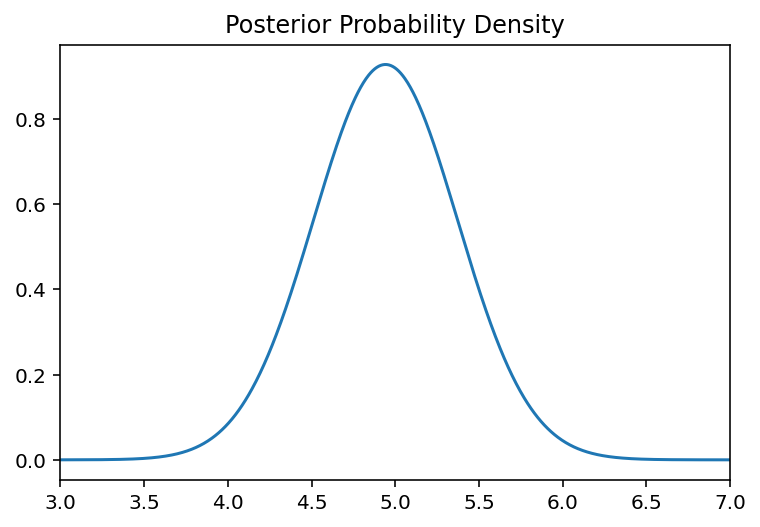

In [184]:
#3 setting up the bayesian posterior
#using the example in lecture 8

#create a grid of possible mu
xgrid = np.linspace(3, 7, 1000) 
# likelihood for gaussian
def gauss_likely(mu,x,dx):
    dist = np.exp(-0.5 * np.sum(((x - mu) / dx) ** 2))
    return dist

# prior need to be uniform
def prior(theta,mu,sc):
    # put a prior distribution here
    dist =uniform.pdf(theta,loc=mu - sc/2, scale=sc)
    return dist

# get the likelyhood for each mu
likelyhood = np.array( [gauss_likely(mu, voltage, verror) for mu in xgrid])


prdist=prior(xgrid,wm,4)
#plt.plot(xgrid,prdist)
proba1 = (likelyhood*prdist)#formula for a posteior dist
normp1=proba1/np.trapz(proba1,xgrid)#normalize
# posterior plot
plt.plot(xgrid, normp1)
plt.title("Posterior Probability Density")
plt.xlim(3,7)

### Part 4

MAP value formula

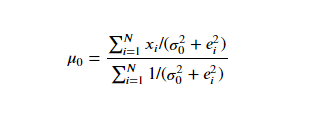

4.513513513513514 5.374374374374375 MAP value is 4.941941941941942


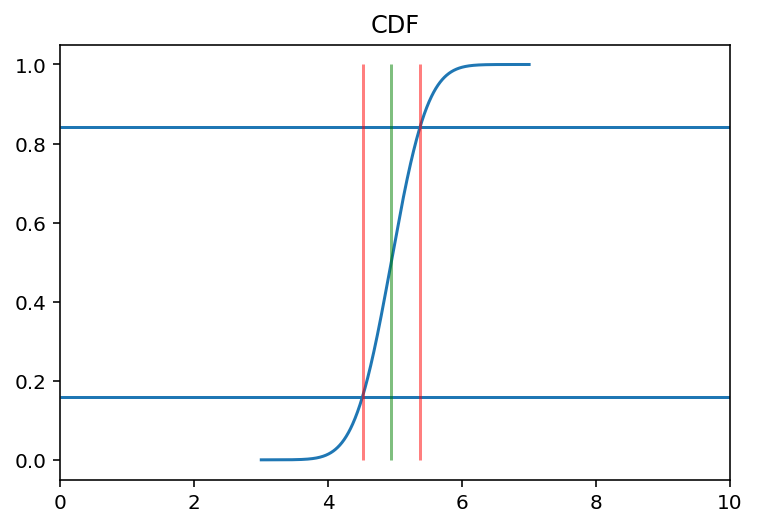

In [185]:
#creating a cdf by summing the posterior and normalize
cdf=np.cumsum(normp1)/np.sum(normp1)
plt.plot(xgrid,cdf)
plt.title('CDF')
plt.xlim(0,10)

# Finding the credible region
lower = xgrid[np.searchsorted(cdf, 0.1585)]
upper = xgrid[np.searchsorted(cdf, 0.8415)]

#Find the MAP value 
map_value =xgrid[np.argmax(normp1)]
#checking where the confindence interval is with graph
print(lower,upper,"MAP value is",map_value)
plt.hlines(0.1585,0,10)
plt.hlines(0.8415,0,10)
plt.vlines(lower,0,1,color='r',alpha=.5)
plt.vlines(upper,0,1,color='r',alpha=.5)
plt.vlines(map_value,0,1,color='g',alpha=.5)

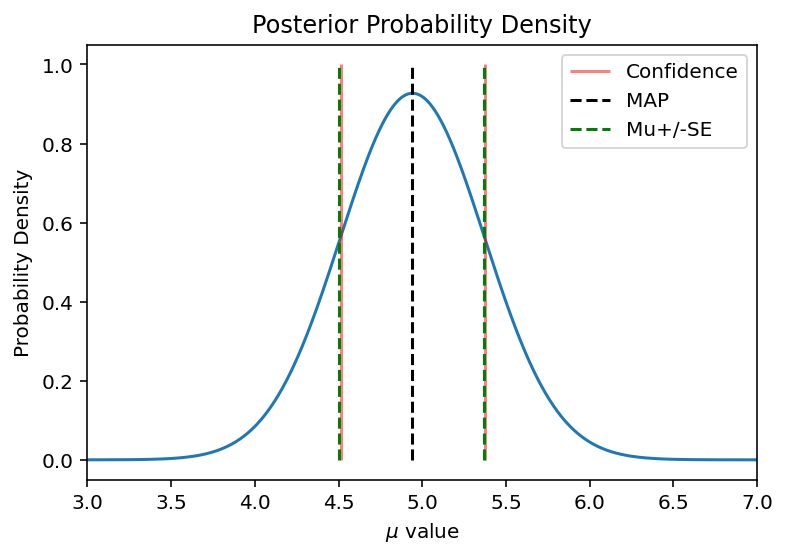

In [186]:
plt.plot(xgrid, normp1)
plt.title("Posterior Probability Density")
plt.xlim(3,7)
#confindence region
plt.vlines(lower,0,1,color='r',alpha=.5,label="Confidence")
plt.vlines(upper,0,1,color='r',alpha=.5)
plt.vlines(map_value,0,1,color='k',linestyle='--',label="MAP")
#lines for mean+/- standard error
plt.vlines(5.37,0,1,color='g',linestyle='--',label="Mu+/-SE")
plt.vlines(4.5,0,1,color='g',linestyle='--')

plt.xlabel("$\mu$ value")
plt.ylabel("Probability Density")
plt.legend()

### Part 5

(3.0, 7.0)

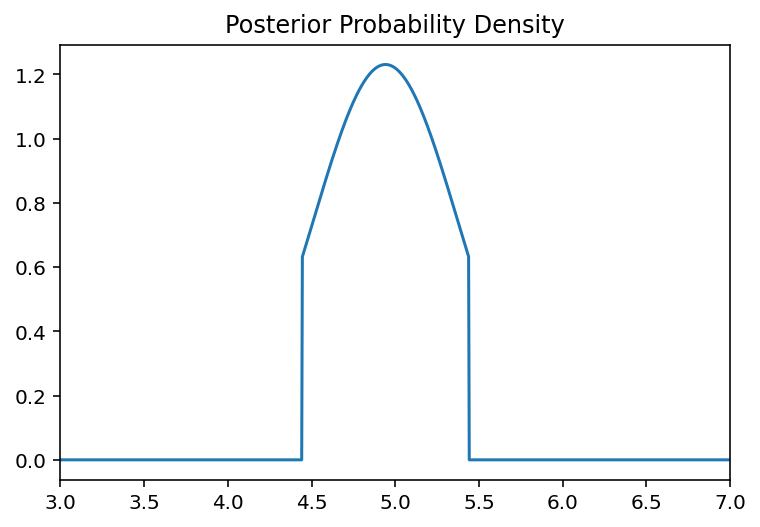

In [205]:
#5 setting up the bayesian posterior
#using the example in lecture 8
#create a grid of possible mu
xgrid = np.linspace(3, 7, 1000) 
# likelihood for gaussian
def gauss_likely(mu,x,dx):
    dist = np.exp(-0.5 * np.sum(((x - mu) / dx) ** 2))
    return dist

# prior need to be uniform
def prior(theta,mu,sc):
    # put a prior distribution here
    dist =uniform.pdf(theta,loc=mu - sc/2, scale=sc)
    return dist

# get the likelyhood for each mu
likelyhood = np.array( [gauss_likely(mu, voltage, verror) for mu in xgrid])


prdist=prior(xgrid,wm,1)
#plt.plot(xgrid,prdist)
proba2 = (likelyhood*prdist)#formula for a posteior dist
normp2=proba2/np.trapz(proba2,xgrid)#normalize
# posterior plot
plt.plot(xgrid, normp2)
plt.title("Posterior Probability Density")
plt.xlim(3,7)

4.641641641641642 5.242242242242242 MAP value is 4.941941941941942


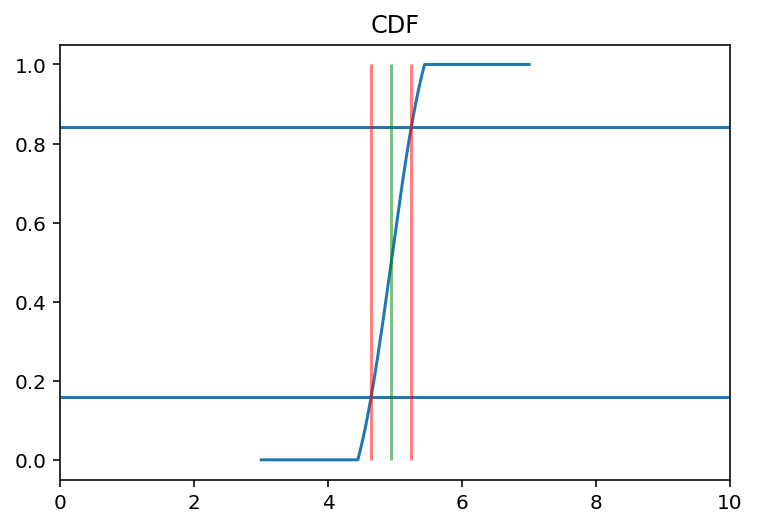

In [188]:
#creating a cdf by summing the posterior
cdf=np.cumsum(normp2)/np.sum(normp2)
plt.plot(xgrid,cdf)
plt.title('CDF')
plt.xlim(0,10)

# Finding the credible region
lower = xgrid[np.searchsorted(cdf, 0.1585)]
upper = xgrid[np.searchsorted(cdf, 0.8415)]

#MAP
map_value =xgrid[np.argmax(normp2)]
#checking where the confindence interval is with graph
print(lower,upper,"MAP value is",map_value)
plt.hlines(0.1585,0,10)
plt.hlines(0.8415,0,10)
plt.vlines(lower,0,1,color='r',alpha=.5)
plt.vlines(upper,0,1,color='r',alpha=.5)
plt.vlines(map_value,0,1,color='g',alpha=.5)

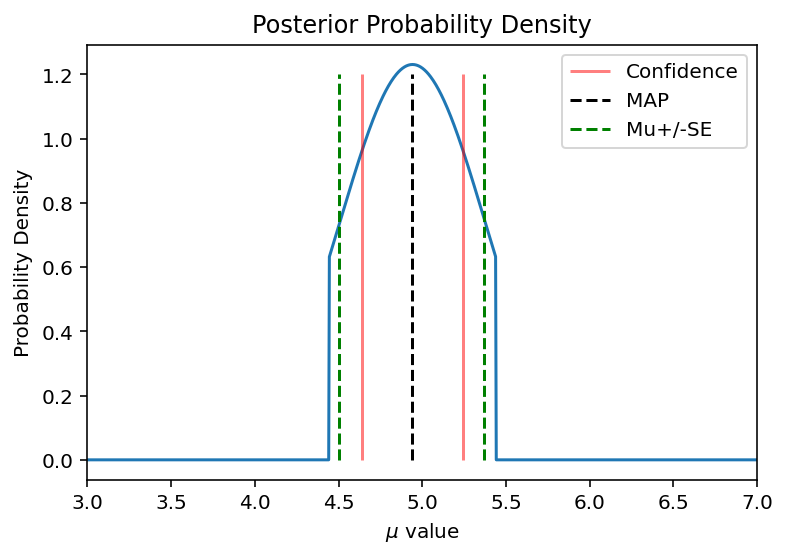

In [189]:
plt.plot(xgrid, normp2)
plt.title("Posterior Probability Density")
plt.xlim(3,7)
#confindence region
plt.vlines(lower,0,1.2,color='r',alpha=.5,label="Confidence")
plt.vlines(upper,0,1.2,color='r',alpha=.5)
plt.vlines(map_value,0,1.2,color='k',linestyle='--',label="MAP")
#lines for mean+/- standard error
plt.vlines(5.37,0,1.2,color='g',linestyle='--',label="Mu+/-SE")
plt.vlines(4.5,0,1.2,color='g',linestyle='--')

plt.xlabel("$\mu$ value")
plt.ylabel("Probability Density")
plt.legend()

### Part 6

(3.0, 7.0)

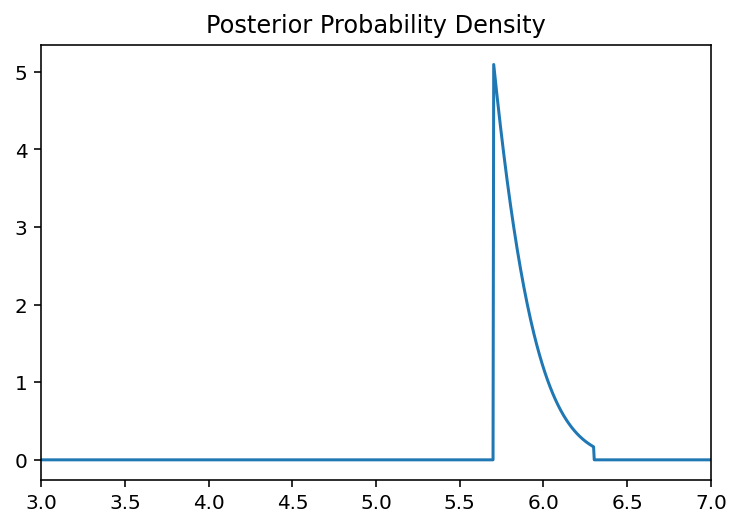

In [206]:
#5 setting up the bayesian posterior
#using the example in lecture 8
#create a grid of possible mu
xgrid = np.linspace(3, 7, 1000) 
# likelihood for gaussian
def gauss_likely(mu,x,dx):
    dist = np.exp(-0.5 * np.sum(((x - mu) / dx) ** 2))
    return dist

# prior need to be uniform
def prior(theta,mu,sc):
    # put a prior distribution here
    dist =uniform.pdf(theta,loc=mu - sc/2, scale=sc)
    return dist

# get the likelyhood for each mu
likelyhood = np.array( [gauss_likely(mu, voltage, verror) for mu in xgrid])


prdist=prior(xgrid,6,.6)
#plt.plot(xgrid,prdist)
proba3 = (likelyhood*prdist)#formula for a posteior dist
normp3=proba3/np.trapz(proba3,xgrid)#normalize
# posterior plot
plt.plot(xgrid, normp3)
plt.title("Posterior Probability Density")
plt.xlim(3,7)

5.734734734734735 6.003003003003003 MAP value is 5.702702702702703


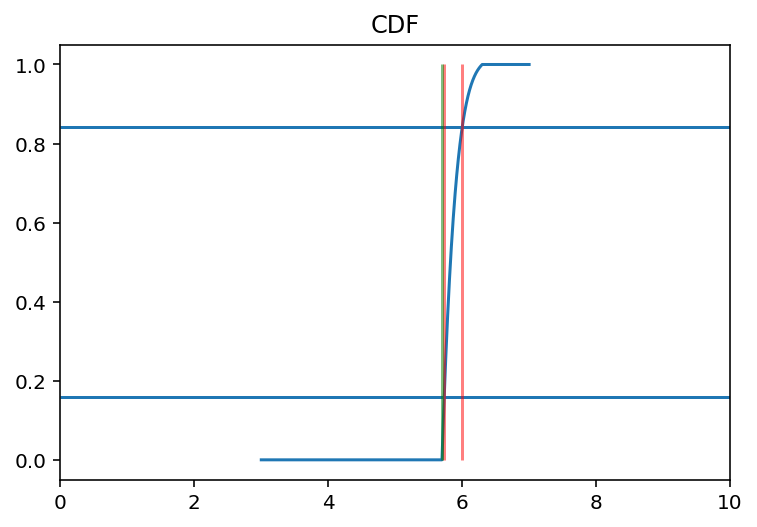

In [191]:
#creating a cdf by summing the posterior and normalizing 
cdf=np.cumsum(normp3)/np.sum(normp3)
plt.plot(xgrid,cdf)
plt.title('CDF')
plt.xlim(0,10)

# Finding the credible region
lower = xgrid[np.searchsorted(cdf, 0.1585)]
upper = xgrid[np.searchsorted(cdf, 0.8415)]

#MAP
map_value =xgrid[np.argmax(normp3)]
#checking where the confindence interval is with graph
print(lower,upper,"MAP value is",map_value)
plt.hlines(0.1585,0,10)
plt.hlines(0.8415,0,10)
plt.vlines(lower,0,1,color='r',alpha=.5)
plt.vlines(upper,0,1,color='r',alpha=.5)
plt.vlines(map_value,0,1,color='g',alpha=.5)

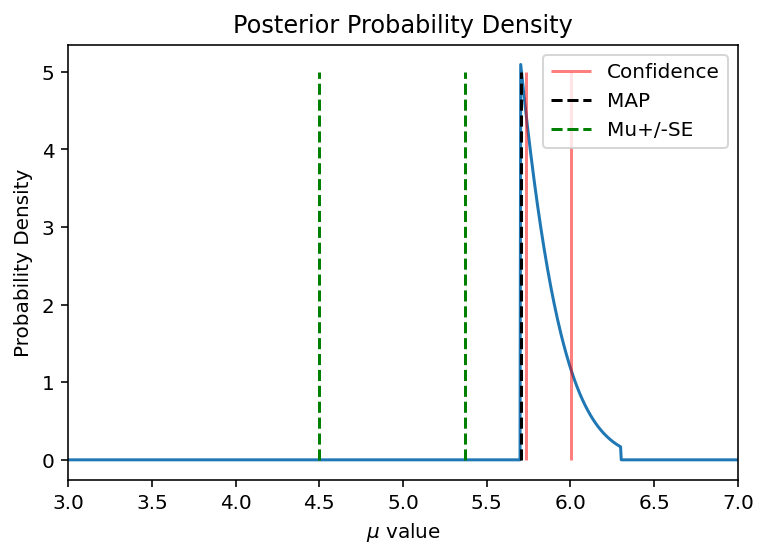

In [202]:
plt.plot(xgrid, normp3)
plt.title("Posterior Probability Density")
plt.xlim(3,7)
#confindence region
plt.vlines(lower,0,5,color='r',alpha=.5,label="Confidence")
plt.vlines(upper,0,5,color='r',alpha=.5)
plt.vlines(map_value,0,5,color='k',linestyle='--',label="MAP")
#lines for mean+/- standard error
plt.vlines(5.37,0,5,color='g',linestyle='--',label="Mu+/-SE")
plt.vlines(4.5,0,5,color='g',linestyle='--')
plt.xlabel("$\mu$ value")
plt.ylabel("Probability Density")
plt.legend()

### Part 7

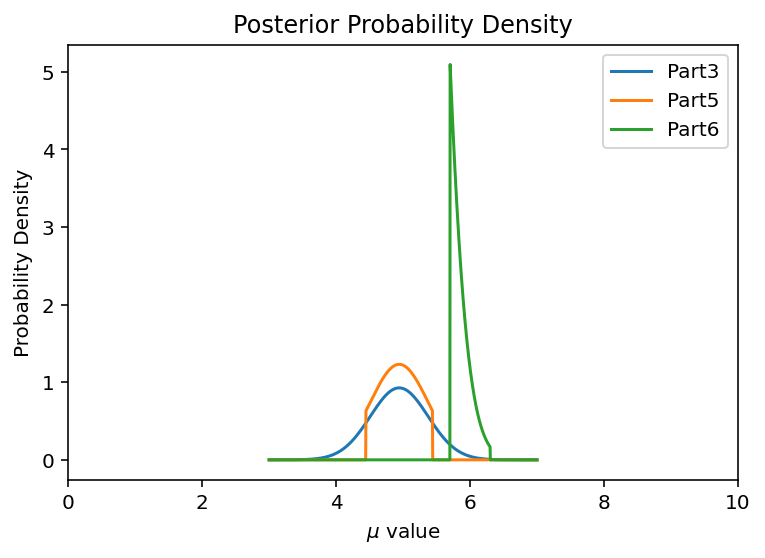

In [203]:
#plotting everything at once
plt.plot(xgrid, normp1,label='Part3')
plt.plot(xgrid, normp2,label='Part5')
plt.plot(xgrid, normp3,label='Part6')
plt.title("Posterior Probability Density")
plt.xlim(0,10)
plt.xlabel("$\mu$ value")
plt.ylabel("Probability Density")
plt.legend()

### Part 8

evidence from part 3 0.016276779242842584
evidence from part 8 0.048343791483534536
bayes factor= 0.3366880987889895


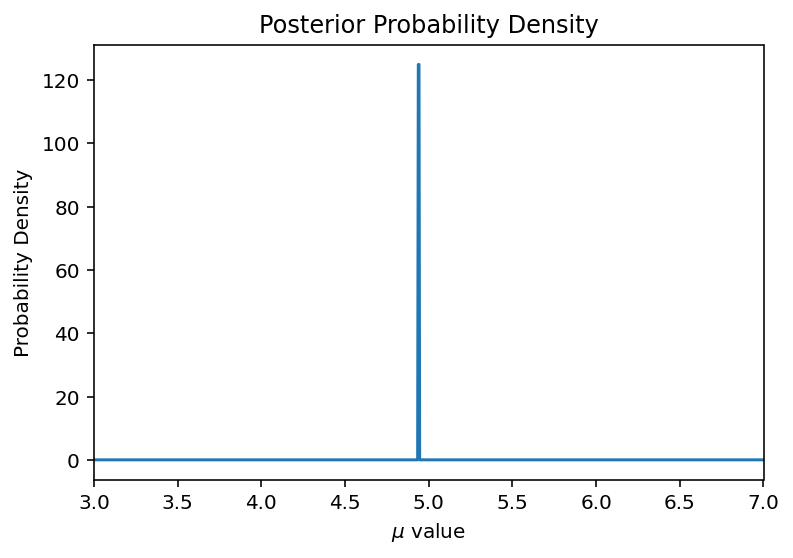

In [204]:
#8
# setting up the bayesian posterior
#using the example in lecture 8

#create a grid of possible mu
xgrid = np.linspace(3, 7, 1000) 
# likelihood for gaussian
def gauss_likely(mu,x,dx):
    dist = np.exp(-0.5 * np.sum(((x - mu) / dx) ** 2))
    return dist

# prior need to be uniform
def prior(theta,mu,sc):
    # put a prior distribution here
    dist =uniform.pdf(theta,loc=mu - sc/2, scale=sc)
    return dist

# get the likelyhood for each mu
likelyhood = np.array( [gauss_likely(mu, voltage, verror) for mu in xgrid])

prdist=prior(xgrid,4.94,0.01) #this width needs to be small to approx a delta func
proba4 = (likelyhood*prdist)#formula for a posteior dist
normp4=proba4/np.trapz(proba4,xgrid)#normalize

# posterior plot
plt.plot(xgrid, normp4)
plt.title("Posterior Probability Density")
plt.xlim(3,7)
plt.xlabel("$\mu$ value")
plt.ylabel("Probability Density")

#getting the bayes factor
x,y=np.trapz(proba1,xgrid),np.trapz(proba4,xgrid)
print("evidence from part 3",np.trapz(proba1,xgrid))
print('evidence from part 8',np.trapz(proba4,xgrid))
ratio=x/y
print('bayes factor=',ratio)

A bayes factor of .33 is not evidence to prefer the exact mean value of the wide distribution. So it seems to have a penalty to having a small width.

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

In [2]:
#1
#read in the data
data=np.load('../../../homeworks/hw_data/hw4_data_2.npy')
#getting the variables
x,y,sigma_y=data
yint=(-.23)

### Part 2

In [3]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

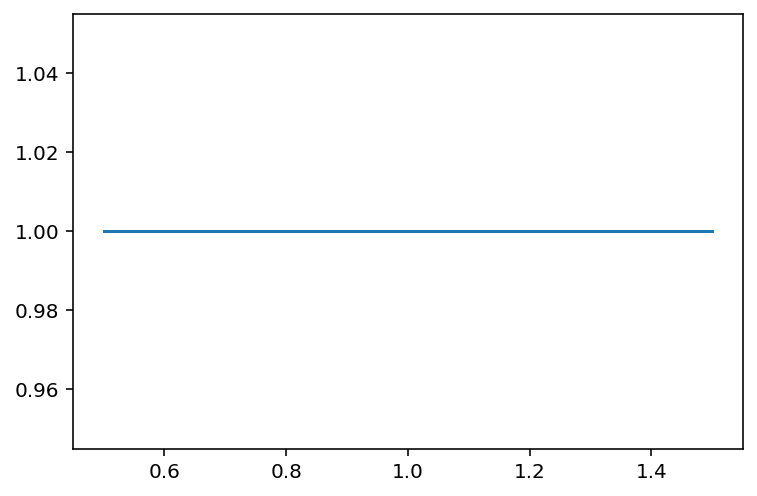

In [4]:
#setting up prior and grid
def prior(theta,mu,sc):
    # put a prior distribution here
    dist =uniform.pdf(theta,loc=mu - sc/2, scale=sc)
    return dist

xgrid=np.linspace(.5,1.5,100)
#plotting to make sure prior looks good
plt.plot(xgrid,prior(xgrid,1,1))

Text(0, 0.5, 'Prob density')

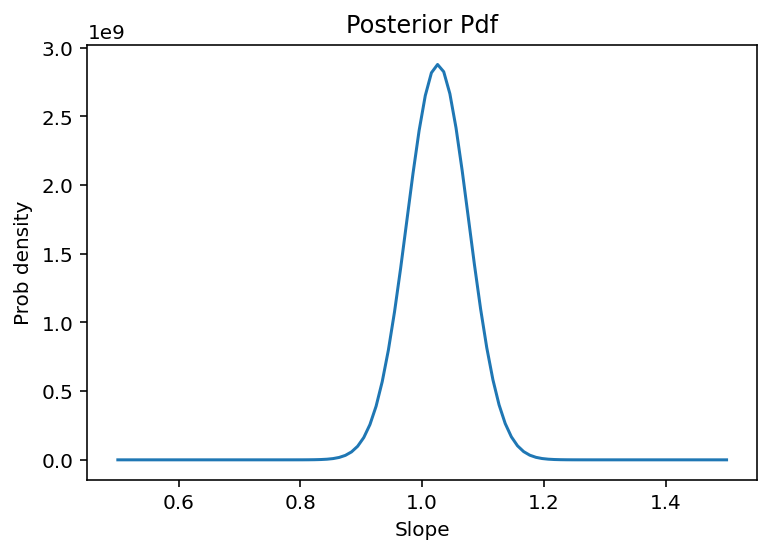

In [5]:
#need a post pdf so likely*prior
#also inlude a fixed yint
post=[np.exp(logL([yint, theta], data)) * prior(theta,1,1) for theta in xgrid]

#plotting
plt.plot(xgrid,post)
plt.title("Posterior Pdf")
plt.xlabel("Slope");plt.ylabel("Prob density")


### Part 3

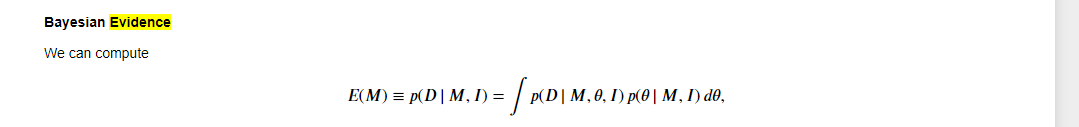

In [6]:
#we only have 1 model above simplifies
#we learned in question 1 we can just compute the normalization coeff
evidence= np.trapz(post, xgrid)
print("Bayesian Evidence",evidence)

Bayesian Evidence 365684733.16065943


### Part 4

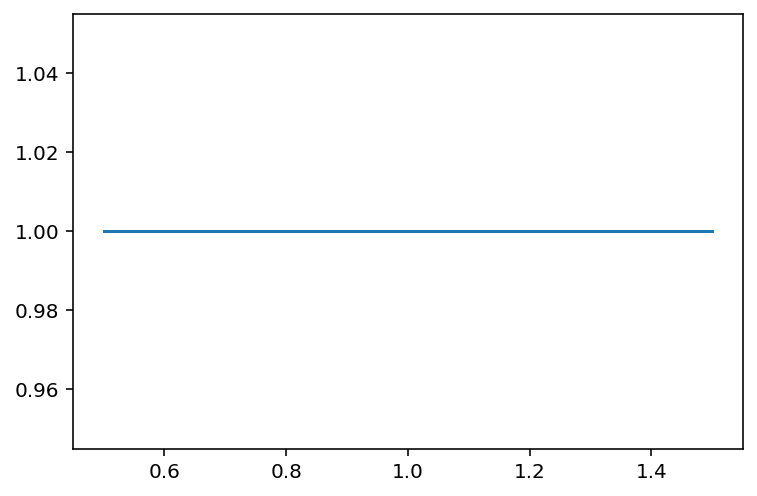

In [7]:
#setting up prior and grid
def prior(theta,mu,sc):
    # prior dist
    dist =uniform.pdf(theta,loc=mu - sc/2, scale=sc)
    return dist

xgrid=np.linspace(.5,1.5,100)
#plotting to make sure prior looks good
plt.plot(xgrid,prior(xgrid,1,1))

In [8]:
#prior for quadratic
#the uniform dist funciton wasn't working so brute force
def prior2(theta2):
    if -1.0 <= theta2 <= 0.25:
        return 1.0 
    else:
        return 0.0
# anohter grid
xgrid2 = np.linspace(-1.0, 0.25, 100)

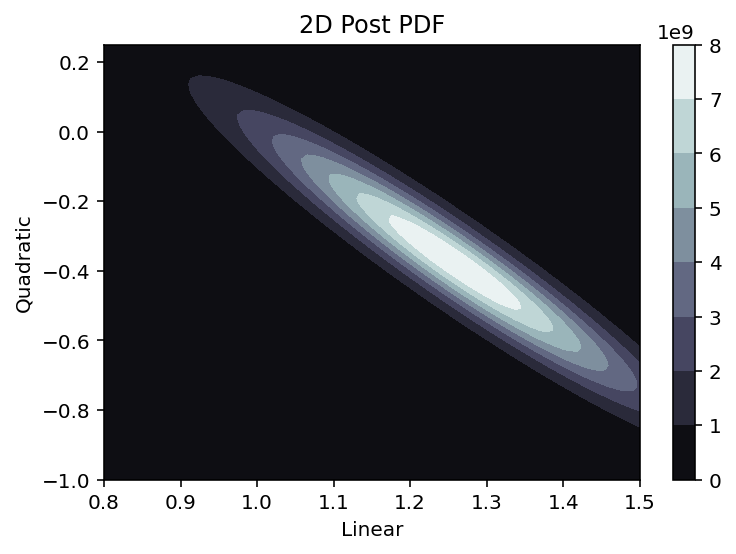

In [10]:
# again we are doing the (likelihood * prior)
#want a 2d array so lets make a zero matrix the size of 100x100
c=(100,100)
post2=np.zeros(c)

#get the pdf value at each point by going through each elemenent
for i, theta in enumerate(xgrid):
    for j, theta2 in enumerate(xgrid2):
        #(likelihood * prior)
        post2[i, j] = (np.exp(logL([-0.23, theta, theta2], data)) * prior(theta,1,1) * prior2(theta2))

# Plotting
x, y = np.meshgrid(xgrid, xgrid2, indexing='ij') 
plt.contourf(x, y, post2,cmap='bone')
plt.colorbar()
plt.title("2D Post PDF")
plt.xlabel('Linear')
plt.ylabel('Quadratic')
plt.xlim(.8,1.5)
plt.show()

### Part 5

In [11]:
# evidence the same as question 1 except now we have 2d intergral
evidence_2 = np.trapz(np.trapz(post2, xgrid2), xgrid)
print("Quad Bayesian Evidence",evidence_2)

Quad Bayesian Evidence 613042113.2712488


### Part 6

In [12]:
#linear is given from part 3
print("Linear Bayesian Evidence",evidence)
#quad from part 5
print("Quad Bayesian Evidence",evidence_2)

ratio=evidence_2/evidence
print("Bayes Factor",ratio)

Linear Bayesian Evidence 365684733.16065943
Quad Bayesian Evidence 613042113.2712488
Bayes Factor 1.676422496429228


When we did the BIC comparison in the lecture we found that the additional parameter was not justified. Here we have a bayes factor of 1.6. This means that the evidence is in the barley worth mentioning regime. This supports what we found in the lecture.